# EDA: Covid-19 statistics in United States from 22-01-2020 till 27-07-2020 

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas

sns.set_style('darkgrid')

## The analyzer

In [2]:
class CoronaEDA_USA:
    def __init__(self):
        self.data = self.loadData()
        states = geopandas.read_file('USA_States/USA_States.shp')
        self.states = states
    
    def loadData(self):
        covid19_df = pd.read_csv('./Dataset/archive/usa_county_wise.csv')
        covid19_df['County'] = covid19_df['Combined_Key'].apply(lambda x: x.split(',')[0])
        covid19_df['Date'] = pd.to_datetime(covid19_df['Date'], format='%m/%d/%y')
        covid19_df.drop(columns=['Combined_Key', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region'], axis=1, inplace=True)    
        return covid19_df
    
    def dataInfo(self):
        return self.data.info()
            
    def confirmedAndDeathByState(self):
        return self.data.groupby('Province_State', as_index=False)[['Confirmed', 'Deaths']].sum().sort_values(by='Deaths', ascending=False)
    
    def deathRateByState(self):
        covid19_states_cd = self.confirmedAndDeathByState()
        covid19_states_cd['Death_Rate'] = 100*covid19_states_cd['Deaths']/covid19_states_cd['Confirmed']
        return covid19_states_cd.drop(['Deaths', 'Confirmed'], axis=1).sort_values(by='Death_Rate', ascending=False)
    
    def plotDeathMap(self):
        covid19_states_cd = self.confirmedAndDeathByState()
        states = self.states.copy()
        states['DEATHS'] = states['STATE_NAME'].map(lambda x: list(covid19_states_cd[covid19_states_cd['Province_State']==x]['Deaths'])[0])
        states.plot(column='DEATHS',cmap='Reds', legend=True, figsize=(15,10))
        plt.title('Death Cases')
        
    def plotConfirmedMap(self):
        covid19_states_cd = self.confirmedAndDeathByState()
        states = self.states.copy()
        states['CONFIRMED'] = states['STATE_NAME'].map(lambda x: list(covid19_states_cd[covid19_states_cd['Province_State']==x]['Confirmed'])[0])
        states.plot(column='CONFIRMED',cmap='Oranges', legend=True, figsize=(15,10))
        plt.title('Confirmed Cases')
    
    def plotDeathRateMap(self):
        covid19_states_deathrate = self.deathRateByState()
        states = self.states.copy()
        states['DEATH_RATE'] = states['STATE_NAME'].map(lambda x: list(covid19_states_deathrate[covid19_states_deathrate['Province_State']==x]['Death_Rate'])[0])
        states.plot(column='DEATH_RATE',cmap='jet', legend=True, figsize=(15,10))
        plt.title('Death Rate')
     
    def getDataFrame(self):
        return self.data   
    
analyzer = CoronaEDA_USA()  
analyzer.dataInfo()
analyzer.getDataFrame()      

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627920 entries, 0 to 627919
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   UID             627920 non-null  int64         
 1   Province_State  627920 non-null  object        
 2   Lat             627920 non-null  float64       
 3   Long_           627920 non-null  float64       
 4   Date            627920 non-null  datetime64[ns]
 5   Confirmed       627920 non-null  int64         
 6   Deaths          627920 non-null  int64         
 7   County          627920 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 38.3+ MB


,UID,Province_State,Lat,Long_,Date,Confirmed,Deaths,County
0,16,American Samoa,-14.271000,-170.132000,2020-01-22,0,0,American Samoa
1,316,Guam,13.444300,144.793700,2020-01-22,0,0,Guam
2,580,Northern Mariana Islands,15.097900,145.673900,2020-01-22,0,0,Northern Mariana Islands
3,63072001,Puerto Rico,18.180117,-66.754367,2020-01-22,0,0,Adjuntas
4,63072003,Puerto Rico,18.360255,-67.175131,2020-01-22,0,0,Aguada
...,...,...,...,...,...,...,...,...
627915,84070016,Utah,39.372319,-111.575868,2020-07-27,347,1,Central Utah
627916,84070017,Utah,38.996171,-110.701396,2020-07-27,70,0,Southeast Utah
627917,84070018,Utah,37.854472,-111.441876,2020-07-27,2781,23,Southwest Utah
627918,84070019,Utah,40.124915,-109.517442,2020-07-27,142,0,TriCounty


### Features Explanation
__Province_State__: The state which the data collected from. \
__(Lat,Long)__: The cooredinate of the state. \
__Date__: The date per day which varies in range 22-01-2020 t0 27-07-2020. \
__Confirmed__: The confirmed cases in the specified date. \
__Deaths__: The death cases in the specified date. \
__County__: The county of the related state that data collected from. We achieve this feature by splitting the __Combined_Key__ feature from the raw data.


## Confirmed & Death  Cases (Sorted by the number of Death cases)

In [8]:
analyzer.confirmedAndDeathByState().style.background_gradient(cmap='YlOrRd')

,Province_State,Confirmed,Deaths
36,New York,39808447,3176945
34,New Jersey,16506714,1221339
25,Massachusetts,9874030,666157
26,Michigan,6690544,576093
17,Illinois,11900637,541672
43,Pennsylvania,8096993,537261
5,California,17618695,481757
7,Connecticut,4239220,374346
11,Florida,12657802,292541
22,Louisiana,5383429,285084


## Death Rate
Death_Rate: number of deaths divided by number of confirmed cases

In [9]:
covid19_states_deathrate = analyzer.deathRateByState()
covid19_states_deathrate.head(5)

,Province_State,Death_Rate
47,South Dakota,14.383217
7,Connecticut,8.830540
26,Michigan,8.610555
39,Northern Mariana Islands,8.391098
36,New York,7.980580


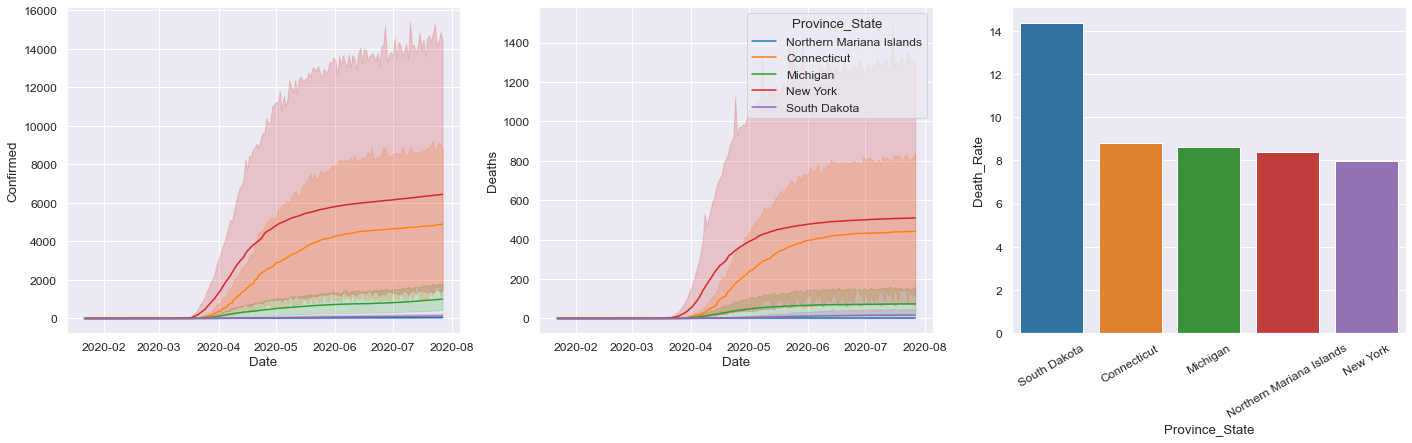

In [11]:
sns.set_context('notebook', font_scale=1.1)
ax = plt.figure(figsize=(24,6)).subplots(1,3)
most_affected = covid19_states_deathrate.head(5)['Province_State']

sns.lineplot(data=analyzer.getDataFrame()[analyzer.getDataFrame()['Province_State'].isin(most_affected)], x='Date', y='Confirmed', hue='Province_State', ax=ax[0], legend=False)
sns.lineplot(data=analyzer.getDataFrame()[analyzer.getDataFrame()['Province_State'].isin(most_affected)], x='Date', y='Deaths', hue='Province_State', ax=ax[1])
sns.barplot(data=covid19_states_deathrate[covid19_states_deathrate['Province_State'].isin(most_affected)], x='Province_State', y='Death_Rate', ax=ax[2])

ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=30)

plt.show()

## Death Cases & Confirmed Cases & Death Rate Map

c:\Dev\Python\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


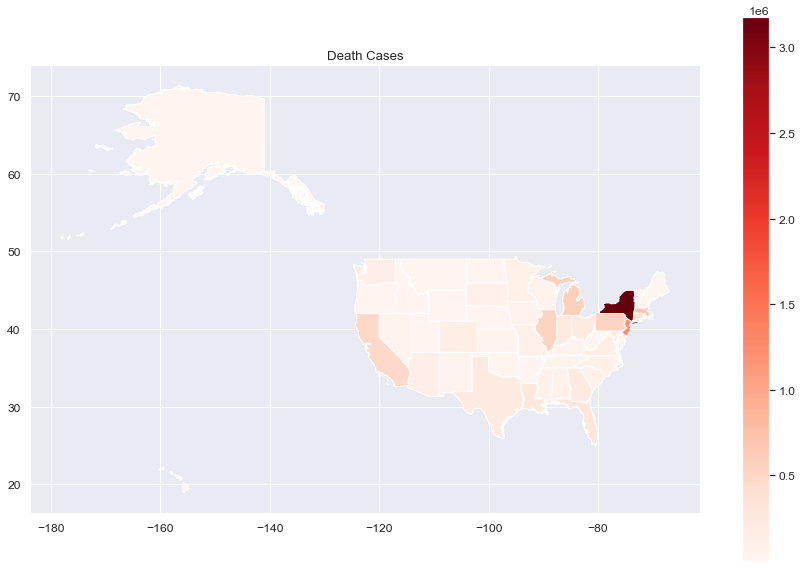

In [12]:
analyzer.plotDeathMap()

c:\Dev\Python\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


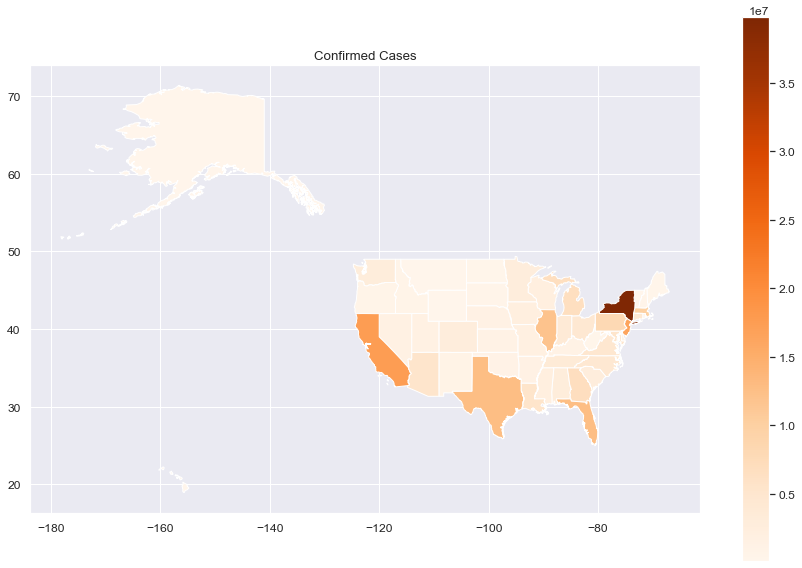

In [13]:
analyzer.plotConfirmedMap()

c:\Dev\Python\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


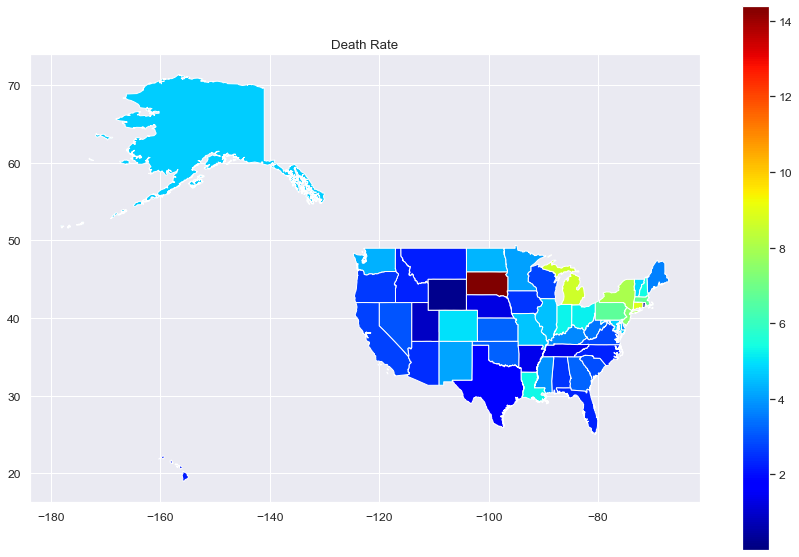

In [14]:
analyzer.plotDeathRateMap()

## Vaccination progress 

In [32]:
class VaccineEDA_US:
    def __init__(self):
        self.data = pd.read_csv('./Dataset/us_state_vaccinations.csv')
        self.data['date'] = pd.to_datetime(self.data['date'], format='%Y-%m-%d')
    
    def dataInfo(self):
        return self.data.info()
    
    def getDataFrame(self):
        return self.data
    
    def plotCriticalMeasures(self, state):
        fig = plt.figure(figsize=(30,15))
        ax = fig.subplots(2,2)
        state_df = self.data[self.data['location']==state]
        # Seaborn automatically fills NaNs. 
        sns.lineplot(data=state_df, x='date', y='total_vaccinations', ax=ax[0,0])
        sns.lineplot(data=state_df, x='date', y='total_vaccinations_per_hundred', ax=ax[0,1])
        sns.lineplot(data=state_df, x='date', y='people_fully_vaccinated', ax=ax[1,0])
        sns.lineplot(data=state_df, x='date', y='people_fully_vaccinated_per_hundred', ax=ax[1,1])

        fig.suptitle(f'Criticals (state: {state})', fontsize=40)
        
vaccine_analyzer = VaccineEDA_US() 
vaccine_analyzer.dataInfo()
vaccine_analyzer.getDataFrame()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54628 entries, 0 to 54627
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 54628 non-null  datetime64[ns]
 1   location                             54628 non-null  object        
 2   total_vaccinations                   32532 non-null  float64       
 3   total_distributed                    32272 non-null  float64       
 4   people_vaccinated                    32268 non-null  float64       
 5   people_fully_vaccinated_per_hundred  30651 non-null  float64       
 6   total_vaccinations_per_hundred       30750 non-null  float64       
 7   people_fully_vaccinated              32188 non-null  float64       
 8   people_vaccinated_per_hundred        30726 non-null  float64       
 9   distributed_per_hundred              30730 non-null  float64       
 10  daily_vacc

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used,total_boosters,total_boosters_per_hundred
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.45,7.69,NaN,NaN,NaN,0.207,NaN,NaN
1,2021-01-13,Alabama,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.53,7.73,5906.0,5906.0,1205.0,0.222,NaN,NaN
2,2021-01-14,Alabama,92300.0,435350.0,80480.0,NaN,1.88,NaN,1.64,8.88,8260.0,7083.0,1445.0,0.212,NaN,NaN
3,2021-01-15,Alabama,100567.0,444650.0,86956.0,0.28,2.05,13488.0,1.77,9.07,8267.0,7478.0,1525.0,0.226,NaN,NaN
4,2021-01-16,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7498.0,1529.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54623,2023-05-06,Wyoming,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,133.0,NaN,NaN,NaN
54624,2023-05-07,Wyoming,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,173.0,NaN,NaN,NaN
54625,2023-05-08,Wyoming,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.0,213.0,NaN,NaN,NaN
54626,2023-05-09,Wyoming,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,146.0,252.0,NaN,NaN,NaN


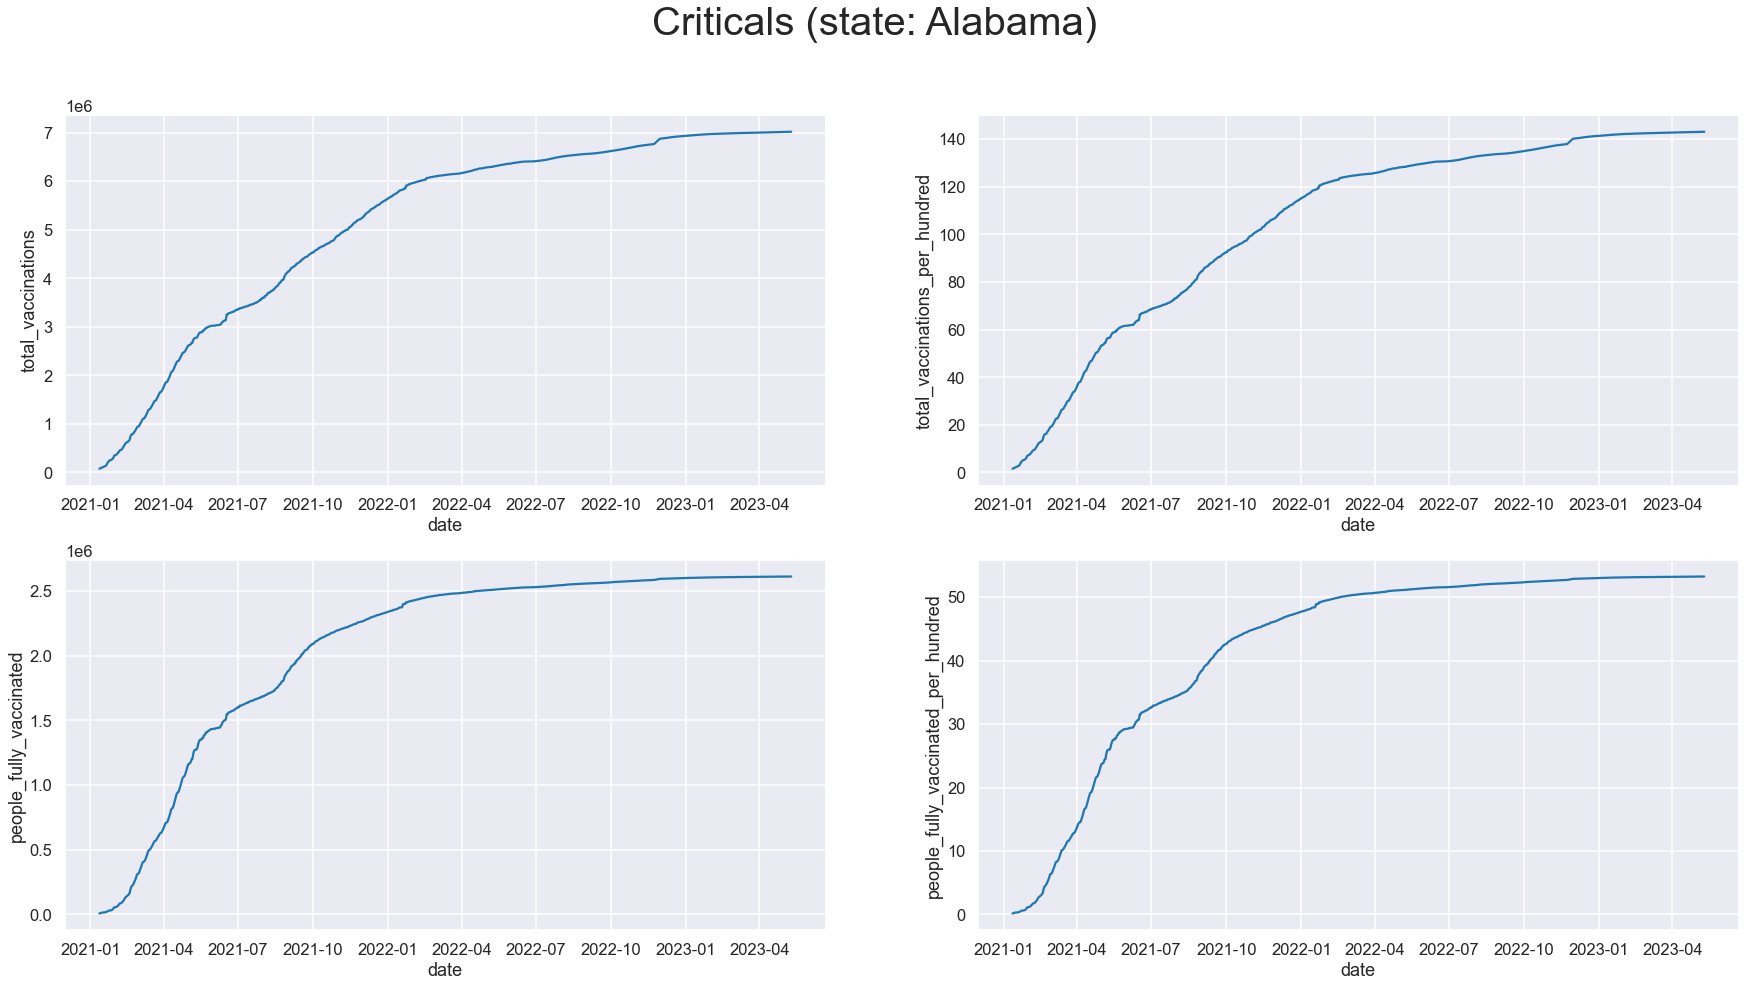

In [33]:
sns.set_context('talk')
vaccine_analyzer.plotCriticalMeasures(state='Alabama')

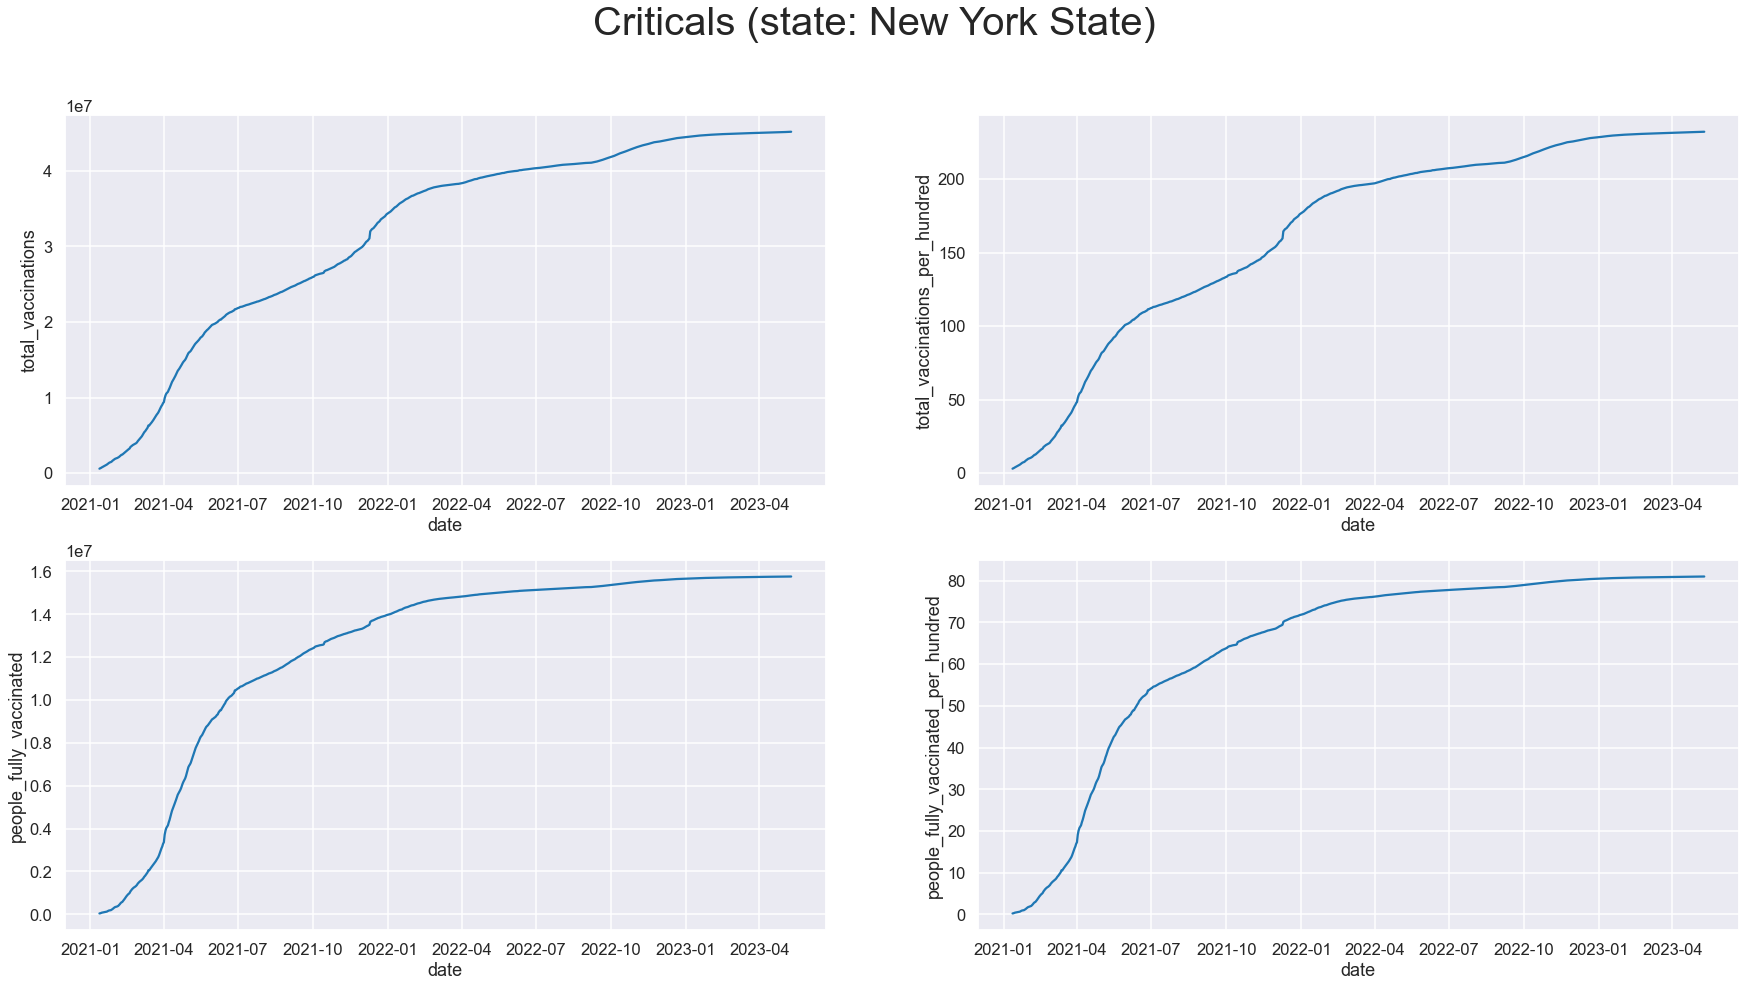

In [34]:
vaccine_analyzer.plotCriticalMeasures(state='New York State')

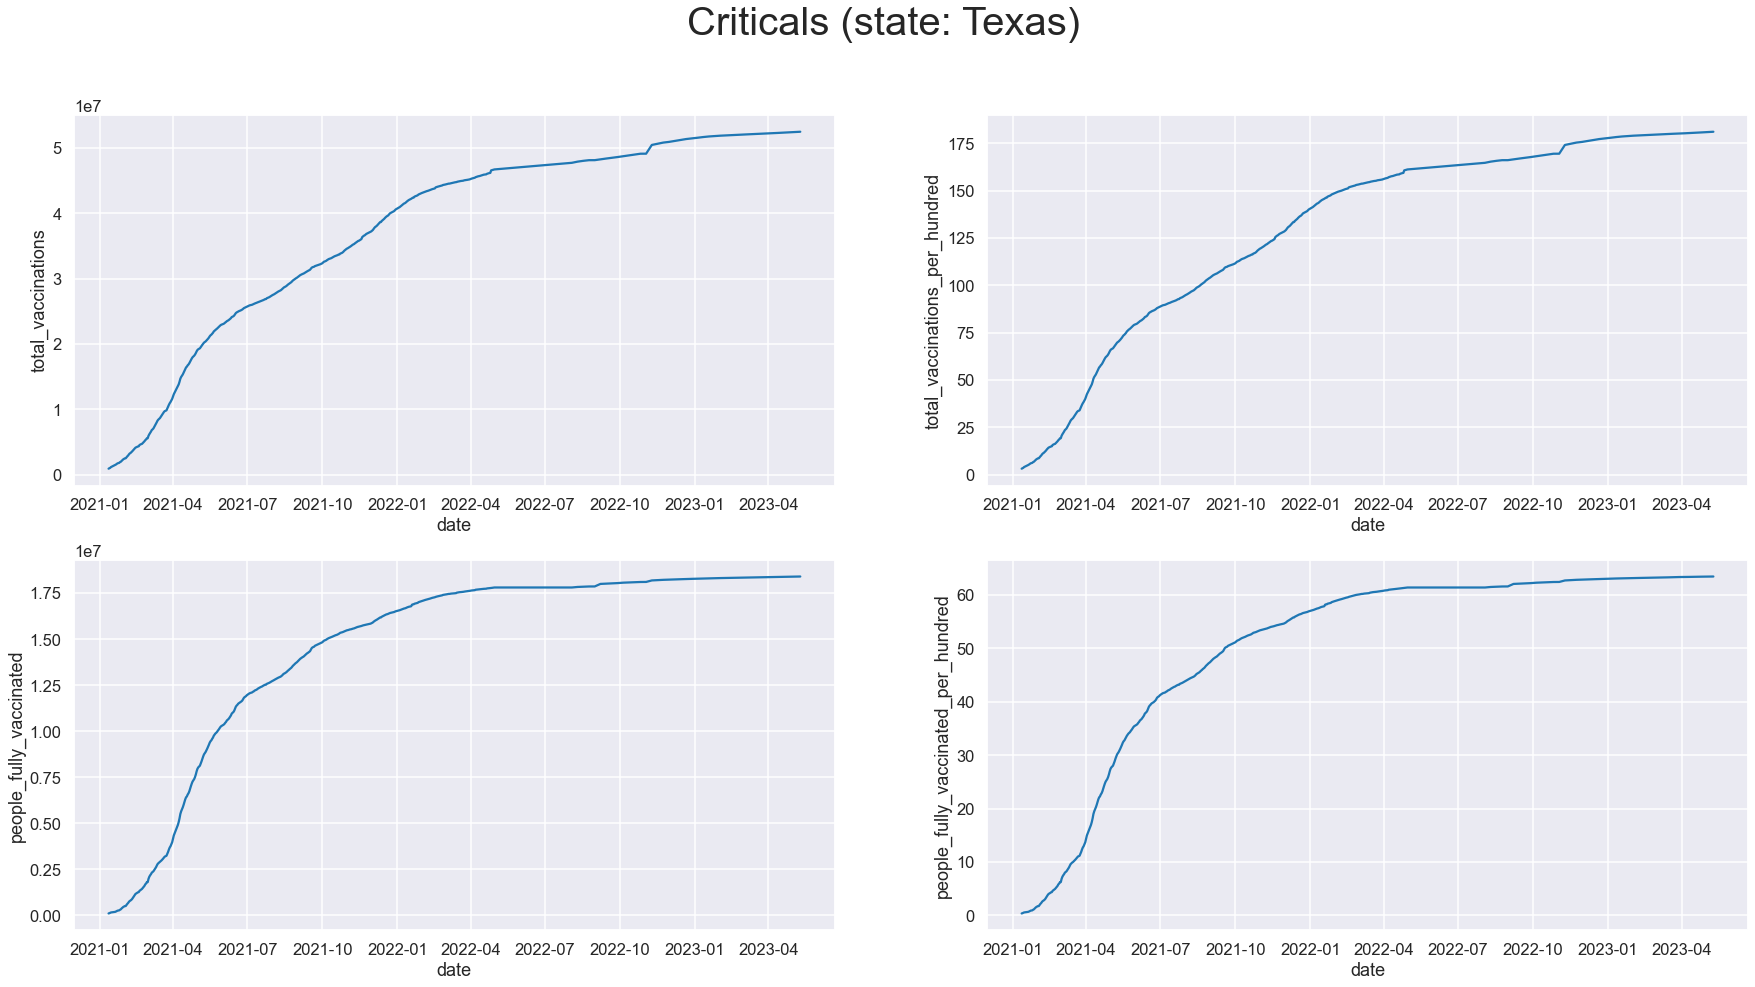

In [35]:
vaccine_analyzer.plotCriticalMeasures(state='Texas')